In [1]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Read data into Python

In [2]:
actions_df = pd.read_csv('actions.csv')
users_df = pd.read_csv('users.csv')
villages_df = pd.read_csv('villages.csv')

print(f"Number of actions: {len(actions_df)}")
print(f"Number of users: {len(users_df)}")
print(f"Number of villages: {len(villages_df)}")

Number of actions: 7380
Number of users: 285
Number of villages: 100


## 2. Visualize data using matplotlib

### Content Type Visualisation

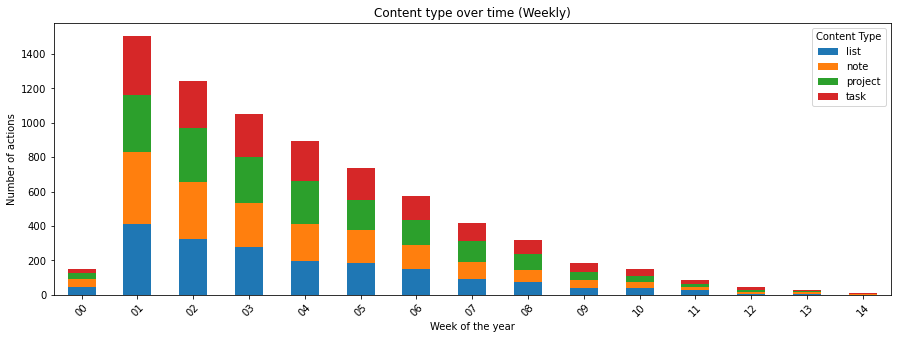

In [3]:
# Importing required libraries
import matplotlib.pyplot as plt

def plot_content_type_over_time(df, title):
    """
    This function takes in a DataFrame and a title, and then plots the distribution of content types 
    over time using a stacked bar chart. The data is aggregated on a weekly basis.

    :param df: DataFrame containing the datetime and content_type columns
    :param title: Title of the plot
    """

    # Convert the 'datetime' column into a pandas datetime object
    df['date'] = pd.to_datetime(df['datetime'])
    
    # Set the newly converted 'date' column as the index for the DataFrame
    # This facilitates easy resampling (aggregation) of data
    df.set_index('date', inplace=True)

    # Resample the data on a weekly basis ('W' stands for week)
    # For each week, we get the count of each unique content type and 
    # unstack it to get a wide format data, filling missing values with 0
    df_resampled = df.resample('W')['content_type'].value_counts().unstack(fill_value=0)
    
    # Plotting the aggregated data using a stacked bar chart
    df_resampled.plot(kind='bar', stacked=True, figsize=(15, 5))

    # Setting the title and labels for the axes
    plt.title(title)
    plt.xlabel('Week of the year')
    plt.ylabel('Number of actions')

    # Extracting the week number from the date index to use as x-axis ticks
    week_numbers = df_resampled.index.strftime('%W')
    
    # Setting the week numbers as labels for the x-axis, and rotating them 45 degrees for better visibility
    plt.xticks(range(len(week_numbers)), week_numbers, rotation=45)
    
    # Adding a legend with a title
    plt.legend(title='Content Type')
    
    # Display the plot
    plt.show()

# Sample call to the function to visualize content type over time (weekly basis)
plot_content_type_over_time(actions_df, 'Content type over time (Weekly)')


### User Kind Visualisation

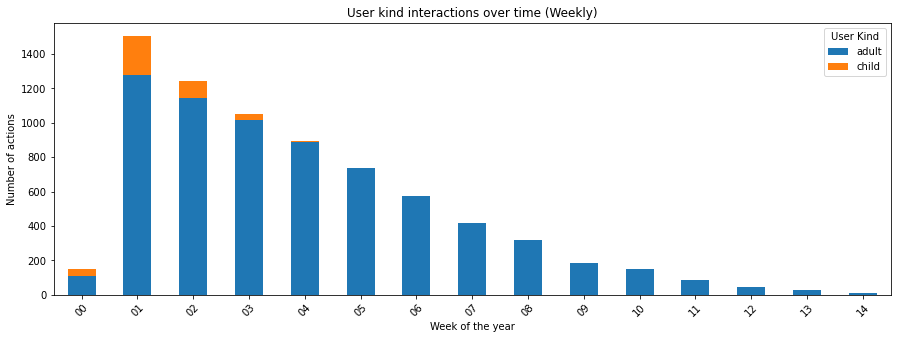

In [4]:
# Import necessary libraries
import matplotlib.pyplot as plt

# The goal of this script is to plot user interactions over time, segmented by user kind.
# We're provided with two dataframes: 
# - `actions_df` which contains actions by each user represented by their `user_id`
# - `users_df` which contains details of each user, specifically their `id` and their `kind` (type)

# Start by merging the two dataframes on corresponding user identifiers.
# This way, each action will be paired with the type of user who performed it.
merged_df = pd.merge(actions_df, users_df, left_on='user_id', right_on='id')

# Now that we have merged the dataframes, the 'id' column from the users_df is redundant since
# it is identical to the 'user_id' column. Thus, we drop it.
merged_df.drop('id', axis=1, inplace=True)

# Convert the 'datetime' column to actual datetime data type to facilitate time-based operations.
merged_df['date'] = pd.to_datetime(merged_df['datetime'])

# Set the converted 'date' column as the index of the dataframe. 
# This will allow us to resample (aggregate) data based on time periods.
merged_df.set_index('date', inplace=True)

# Aggregate data on a weekly basis. For each week, count the number of interactions
# by each user kind. The `unstack` function is used to reshape the result, filling missing values with 0.
merged_df_resampled = merged_df.resample('W')['kind'].value_counts().unstack(fill_value=0)

# With our data ready, plot the aggregated user interactions.
# This will be a stacked bar chart with each segment of the bar representing a user kind.
merged_df_resampled.plot(kind='bar', stacked=True, figsize=(15, 5))

# Set the title and axis labels for the plot.
plt.title('User kind interactions over time (Weekly)')
plt.xlabel('Week of the year')
plt.ylabel('Number of actions')

# Extract the week number from the date to make the x-axis labels more readable.
week_numbers = merged_df_resampled.index.strftime('%W')

# Apply these week numbers as x-axis labels and rotate them for better visibility.
plt.xticks(range(len(week_numbers)), week_numbers, rotation=45)

# Add a legend to distinguish between different user kinds.
plt.legend(title='User Kind')

# Finally, display the plot.
plt.show()

### Features Visualisation

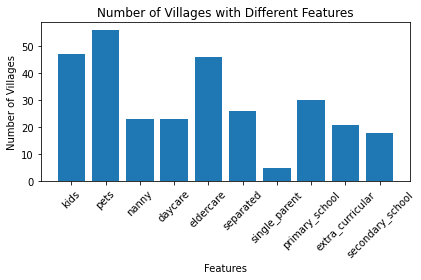

In [5]:
# The purpose of this code is to visualize the number of villages that have certain features.
# We assume that the dataset 'villages_df' represents various villages and their associated features.
# Features with a 'True' value indicate the presence of that feature for a particular village.

# Assign the villages_df to a new variable 'df' for convenience.
df = villages_df

# Count the number of villages having a 'True' value for each feature.
# When we use `sum` on a dataframe with Boolean values, pandas treats `True` as 1 and `False` as 0.
# Summing them along the 0 axis (rows) gives us a count of 'True' values for each feature.
feature_counts = df.sum(axis=0)

# We drop the 'id' column from the feature_counts series as it is not an actual feature.
# It might contain a numeric sum which is irrelevant for our visualization.
feature_counts = feature_counts.drop('id')

# Now, let's plot the data.
# We use a bar chart where the x-axis represents the features and the y-axis represents 
# the count of villages with those features.

# Create a bar plot with features on the x-axis and their counts on the y-axis.
plt.bar(feature_counts.index, feature_counts.values)

# Label the x-axis as 'Features'.
plt.xlabel('Features')

# Label the y-axis as 'Number of Villages'.
plt.ylabel('Number of Villages')

# Provide a title for the plot.
plt.title('Number of Villages with Different Features')

# Rotate the feature labels (ticks) on the x-axis for better readability.
plt.xticks(rotation=45)

# Adjust the layout of the plot to ensure no parts are clipped or overlap.
plt.tight_layout()
plt.show()

#  Score Calculation

## 3.1 Village Score Calculation function definition

In [6]:
# This function calculates the action score for a list of visited actions for a village.
def calculate_action_score(visited_actions: list[pd.Series], weights: dict) -> float:
    
    # TODO: if dict has entry for action kind, use that weight, else use default weight
 
    # Determine the date of the first action and the current action being evaluated.
    first_action_date = visited_actions[0]['datetime']
    current_action_date = visited_actions[-1]['datetime']

    # Calculate the number of days since the first action was taken until the current action.
    days_since_first_action = pd.to_datetime(current_action_date) - pd.to_datetime(first_action_date)
    days_since_first_action = days_since_first_action.days or 1  # Ensure that we don't divide by zero later on
    
    # Initialize the village score to zero. This will keep track of the cumulative score for all actions.
    village_score = 0
    
    weighted_score = 0

    # Iterate over all actions except the last (current) one to calculate their contribution to the score.
    for action in visited_actions[:-1]:
        
        # Calculate how many days have passed since this action was taken relative to the current action.
        diff_from_current_action = pd.to_datetime(current_action_date) - pd.to_datetime(action['datetime'])
        diff_from_current_action = diff_from_current_action.days

        # Calculate the weight for this action based on the time passed since it was taken.
        weight = 1 - (diff_from_current_action / days_since_first_action)

        # If the action was performed by a child, give it additional weight. 
        # This is to make child actions more equitable compared to adult actions.
        if action['kind'] == 'child':
            weight *= 2


        weighted_score += weight * weights.get(action['content_type'], 1)

        # Add this action's weight to the total score.
        village_score += weight

    # Since we're evaluating the current action, its score is always 1. Add it to the total score.
    village_score += 1
    weighted_score += weights.get(visited_actions[-1]['content_type'], 1)

    # Normalize the score to make it a value between 0 and 1 by dividing it by the total number of actions.
    village_score /= len(visited_actions)
    weighted_score /= len(visited_actions)

    # cap the score at 1
    village_score = min(village_score, 1)
    weighted_score = min(weighted_score, 1)

    # Update the score in the main dataframe (actions_df) for the current action date and associated village.
    actions_df.loc[
        (actions_df['datetime'] == current_action_date) & 
        (actions_df['village_id'] == visited_actions[0]['village_id_x']), 
        'score'
    ] = village_score

    actions_df.loc[
        (actions_df['datetime'] == current_action_date) & 
        (actions_df['village_id'] == visited_actions[0]['village_id_x']), 
        'weighted_score'
    ] = weighted_score



    # Return the calculated score.
    return village_score, weighted_score


### Formation of merged user and village dataframe

In [7]:
# We want to correlate actions from the 'actions_df' dataframe with user details from the 'users_df' dataframe.
# This is achieved by merging the two dataframes on common columns: 'user_id' in actions_df and 'id' in users_df.

# Merge 'actions_df' and 'users_df' based on 'user_id' and 'id' respectively.
merged_df = pd.merge(actions_df, users_df, left_on='user_id', right_on='id')

# Once merged, 'id' from 'users_df' becomes redundant as we already have 'user_id'. So, we drop the 'id' column.
merged_df.drop('id', axis=1, inplace=True)

# Sort the merged dataframe by 'datetime' to ensure chronological order of actions.
merged_df.sort_values(by='datetime', inplace=True)

### Exact Score calculation for villages

In [8]:
# Retrieve unique village IDs from the merged dataframe to process actions village-wise.
village_ids = merged_df['village_id_x'].unique()

# (optional) add type of project and assign it a weight
# no entry equals default weight of 1
weight_dict = {
    'list': 1.2,
    'note': 1.3,
}

# Initialize two dictionaries to store:
# 1. Actions visited by a village ('visited_actions')
# 2. Cumulative scores for each village ('village_scores')
visited_actions = {}
village_scores = {}
weighted_village_scores = {}


# For each unique village ID, process its actions and calculate scores.
for village_id in village_ids:
    # Initialize an empty list to store actions associated with this village.
    visited_actions[village_id] = []

    # Filter out actions specific to the current village from the merged dataframe.
    village_actions_df = merged_df[merged_df['village_id_x'] == village_id]

    # Iterate over each action for the current village.
    for index, action in village_actions_df.iterrows():
        # Append the current action to the 'visited_actions' list for this village.
        visited_actions[village_id].append(action)
        
        # Calculate the action score for this village based on the actions visited so far.
        result, weighted_result = calculate_action_score(visited_actions[village_id], weight_dict)
        
        # Store the calculated score in the 'village_scores' dictionary.
        village_scores[village_id] = result
        weighted_village_scores[village_id] = weighted_result

    # Print the calculated score for the current village.
    print(f"Village {village_id} score: {village_scores[village_id]}, weighted_score: {weighted_village_scores[village_id]}")


Village 9f83c84d-4aed-45f4-8583-151bd81ba941 score: 0.4649776453055141, weighted_score: 0.519672131147541
Village 39bafb20-391d-4599-b9a1-d176d933c780 score: 0.45451770451770446, weighted_score: 0.5260683760683764
Village d9ee6b00-9d8e-4764-9ddf-d4b069a63a4b score: 0.47851650836725457, weighted_score: 0.5407960199004974
Village 482ad24f-6a20-4ac2-952d-d6d3583609c3 score: 0.44141012909632565, weighted_score: 0.48795928500496527
Village e8a41e5d-956b-4cb3-b0a9-854d2ff81348 score: 0.46972176759410816, weighted_score: 0.521674070610241
Village b2ff56b2-5d39-4e3b-860d-0c4e6b468e22 score: 0.43001119820828665, weighted_score: 0.47933930571108624
Village 5b97240d-ca2c-4d5a-a735-2e32a6e15879 score: 0.41761363636363635, weighted_score: 0.47916666666666663
Village 9de57330-5da5-4c98-8d84-33301876cadd score: 0.40882034632034625, weighted_score: 0.4526515151515152
Village 6736990c-7c85-4c75-8da8-1db722436cf9 score: 0.41170634920634913, weighted_score: 0.4702876984126984
Village 74d9916b-2bde-4591-9

Village 0749481b-e550-4a48-b2d7-a782bdc048ee score: 0.4533169533169533, weighted_score: 0.5131203931203931
Village d7024ba5-e6a9-4aa1-86be-95fd7d107c1a score: 0.42997658079625295, weighted_score: 0.4852927400468385
Village 8e11b2eb-4c56-4b97-9350-f266ce403695 score: 0.43487179487179506, weighted_score: 0.4872820512820512
Village 1100c7be-0910-4181-8b41-9616edb4711e score: 0.4627450980392159, weighted_score: 0.5041830065359478
Village 27beaa37-4cfe-4c46-8e4d-cf2a4515eb55 score: 0.5101367855398145, weighted_score: 0.5692110405471422
Village aed433fd-38bd-4906-9a2a-05e0b00d8bd3 score: 0.43835978835978845, weighted_score: 0.49370370370370376
Village 419227d2-a556-45a6-8c06-062441accd77 score: 0.4155701754385965, weighted_score: 0.465844298245614
Village 37d5ac9c-054c-4e97-8613-a712f5bf473b score: 0.3957528957528957, weighted_score: 0.4496966354109212
Village d288d118-729f-4262-9523-dd9d7450512c score: 0.4159811985898943, weighted_score: 0.4612808460634549
Village 250df063-818a-4157-8cd4-a1

### 3.2 User (or a group of users) from a village (at random) score calculation function definition

In [9]:
def calculate_user_action_score(visited_actions: list[pd.Series], weights: dict) -> float:
     
    # Determine the date of the first action and the current action being evaluated.
    first_action_date = visited_actions[0]['datetime']
    current_action_date = visited_actions[-1]['datetime']

    # Calculate the number of days since the first action was taken until the current action.
    days_since_first_action = pd.to_datetime(current_action_date) - pd.to_datetime(first_action_date)
    days_since_first_action = days_since_first_action.days or 1  # Ensure that we don't divide by zero later on
    
    # Initialize the village score to zero. This will keep track of the cumulative score for all actions.
    user_score = 0
    weighted_score = 0

    # Iterate over all actions except the last (current) one to calculate their contribution to the score.
    for action in visited_actions[:-1]:
        
        # Calculate how many days have passed since this action was taken relative to the current action.
        diff_from_current_action = pd.to_datetime(current_action_date) - pd.to_datetime(action['datetime'])
        diff_from_current_action = diff_from_current_action.days

        # Calculate the weight for this action based on the time passed since it was taken.
        weight = 1 - (diff_from_current_action / days_since_first_action)

        # If the action was performed by a child, give it additional weight. 
        # This is to make child actions more equitable compared to adult actions.
        if action['kind'] == 'child':
            weight *= 2

        weighted_score += weight * weights.get(action['content_type'], 1)

        # Add this action's weight to the total score.
        user_score += weight

    # Since we're evaluating the current action, its score is always 1. Add it to the total score.
    user_score += 1
    weighted_score += weights.get(visited_actions[-1]['content_type'], 1)

    # Normalize the score to make it a value between 0 and 1 by dividing it by the total number of actions.
    user_score /= len(visited_actions)
    weighted_score /= len(visited_actions)

    # cap the score at 1
    user_score = min(user_score, 1)
    weighted_score = min(weighted_score, 1)

    current_user_id = visited_actions[0]['user_id']
    # Update the score in the main dataframe (actions_df) for the current action date and associated village.
    actions_df.loc[
        (actions_df['datetime'] == current_action_date) & 
        (actions_df['user_id'] == current_user_id), 
       'user_score_'+ str(current_user_id)
    ] = user_score

    actions_df.loc[
        (actions_df['datetime'] == current_action_date) & 
        (actions_df['user_id'] == current_user_id), 
        'user_weighted_score_'+str(current_user_id)
    ] = weighted_score

    # Return the calculated score.
    return user_score, weighted_score


### Updating merged dataframe

In [10]:
# re-merge the dataframes to include score column added to actions_df
merged_df = pd.merge(actions_df, users_df, left_on='user_id', right_on='id')

# drop the id column
merged_df.drop('id', axis=1, inplace=True)
# Sort the merged dataframe by 'datetime' to ensure chronological order of actions.
merged_df.sort_values(by='datetime', inplace=True)

### Plotting user scores against their Village (see Section 3.2)

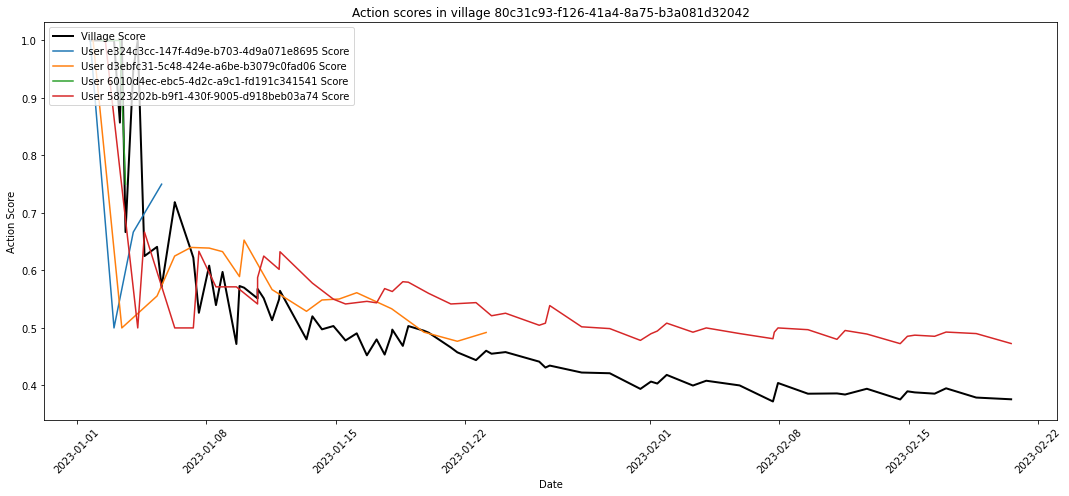

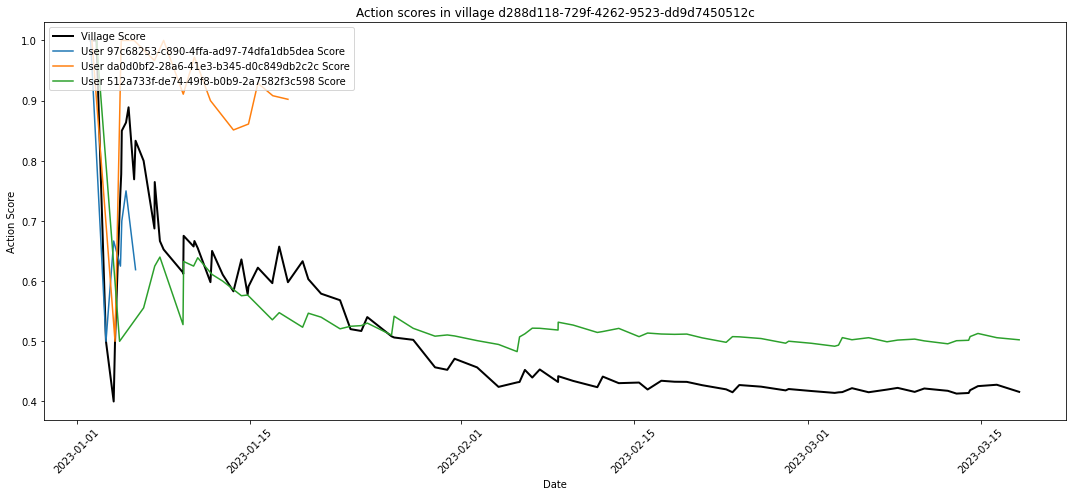

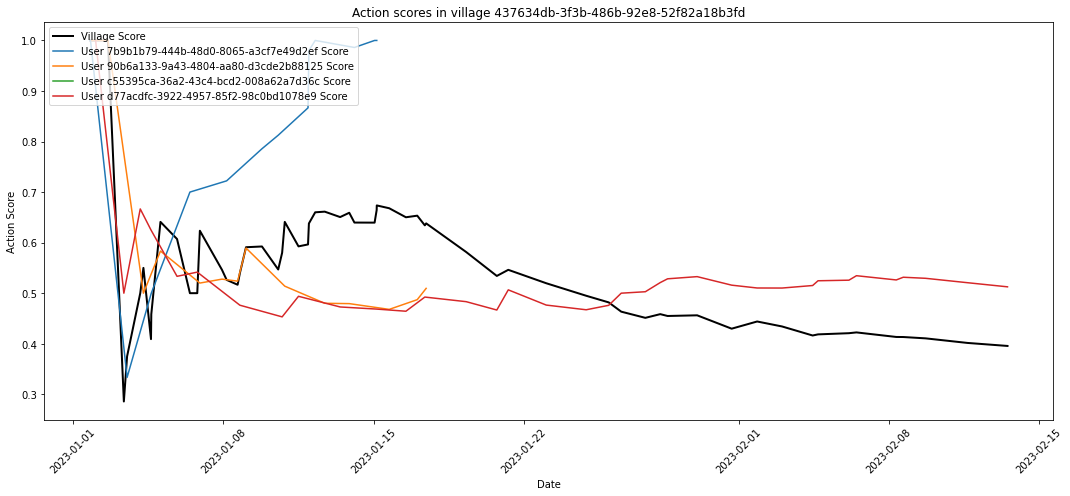

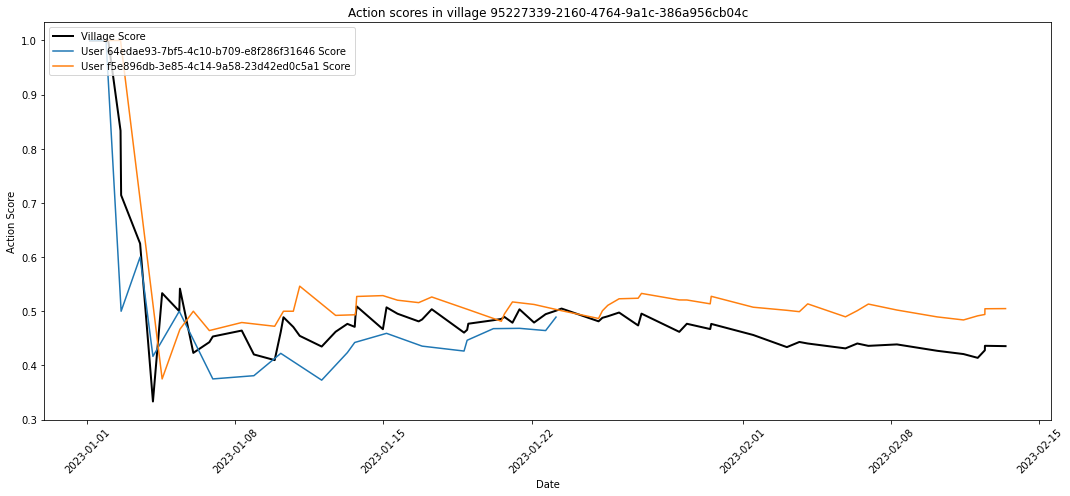

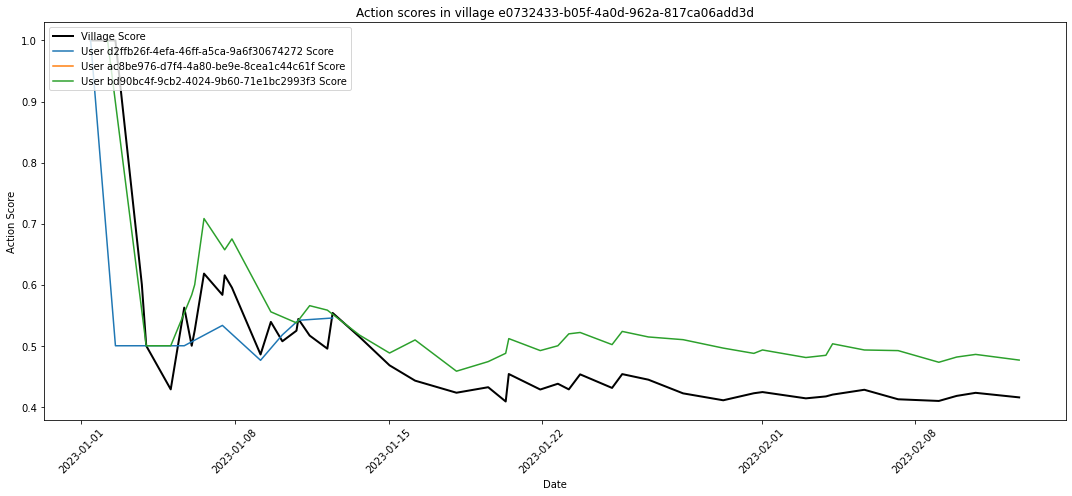

In [11]:
import matplotlib.pyplot as plt
from matplotlib import dates
import pandas as pd

# Sample 5 random villages.
sample_village_ids = merged_df['village_id_x'].sample(5).tolist()

# Loop through each of the sampled village IDs.
for village_id in sample_village_ids:
    
    # Set a larger figure size for clarity.
    plt.figure(figsize=(15, 7))
    
    # Plot village scores:
    village_actions_df = merged_df[merged_df['village_id_x'] == village_id]
    plt.plot(pd.to_datetime(village_actions_df['datetime']), village_actions_df['score'], label='Village Score', color='black', linewidth=2)
    
    # Get all user IDs associated with this village.
    user_ids = merged_df[merged_df['village_id_x'] == village_id]['user_id'].unique()
    
    # Loop through each user ID to calculate and plot their scores.
    for user_id in user_ids:
        visited_actions = []
        user_actions_df = merged_df[(merged_df['user_id'] == user_id) & (merged_df['village_id_x'] == village_id)]

        for _, action in user_actions_df.iterrows():
            visited_actions.append(action)
            _, weighted_result = calculate_user_action_score(visited_actions, weight_dict)

        # Extract the calculated scores for this user from the actions_df dataframe.
        user_scores_for_plotting = actions_df[actions_df['user_id'] == user_id]['user_score_' + str(user_id)]
        user_dates_for_plotting = pd.to_datetime(actions_df[actions_df['user_id'] == user_id]['datetime'])

        plt.plot(user_dates_for_plotting, user_scores_for_plotting, label=f'User {user_id} Score')
    
    plt.legend(loc='upper left')  # Set the legend to the upper left to minimize overlap

    # Set the title of the plot to indicate the village's data and its users being visualized.
    plt.title(f'Action scores in village {village_id}')

    # Label the x-axis as 'Date' since it represents the time of actions.
    plt.xlabel('Date')

    # Rotate the x-axis date labels to prevent overcrowding and format the dates.
    plt.xticks(rotation=45)
    date_format = dates.DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_format)

    # Label the y-axis as 'Action Score'.
    plt.ylabel('Action Score')

    # Ensure elements do not overlap.
    plt.tight_layout()

    # Display the plot.
    plt.show()


### Plotting the user scores against villages with higlighted action dates

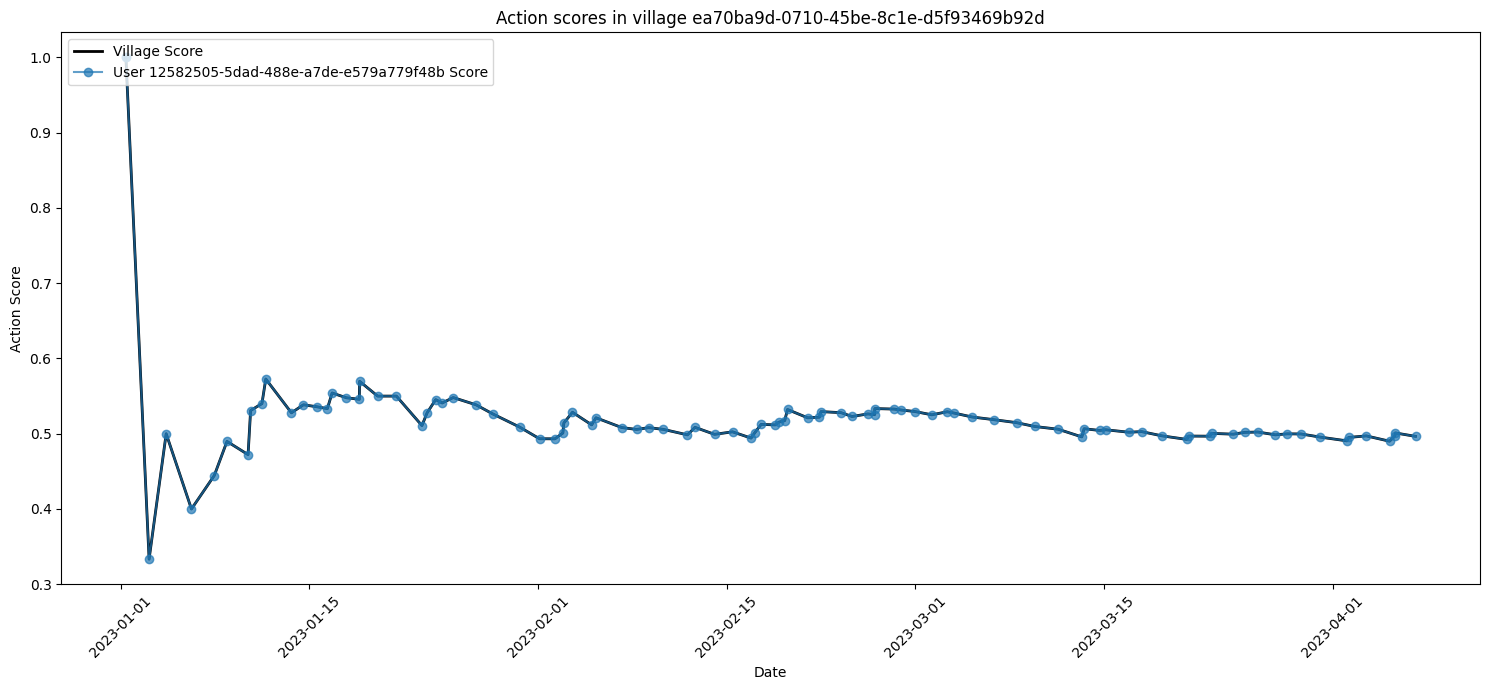

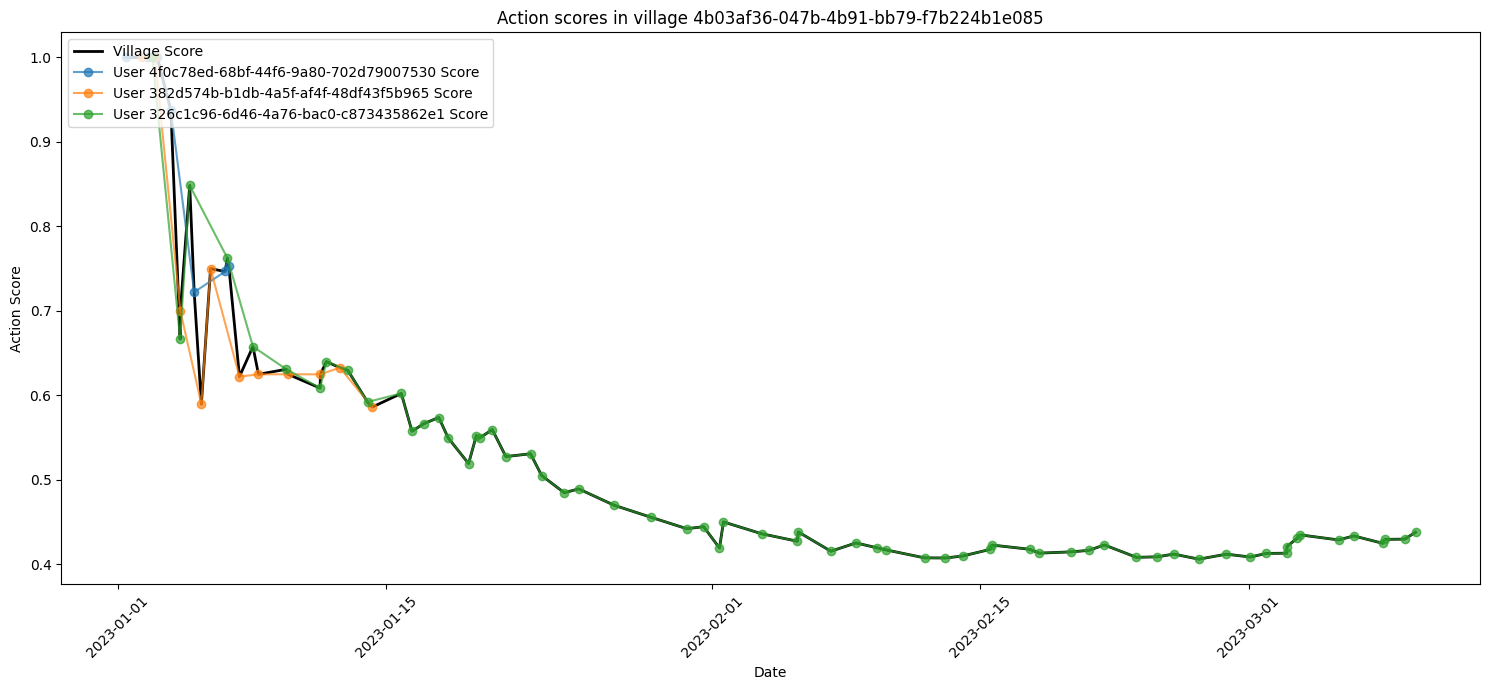

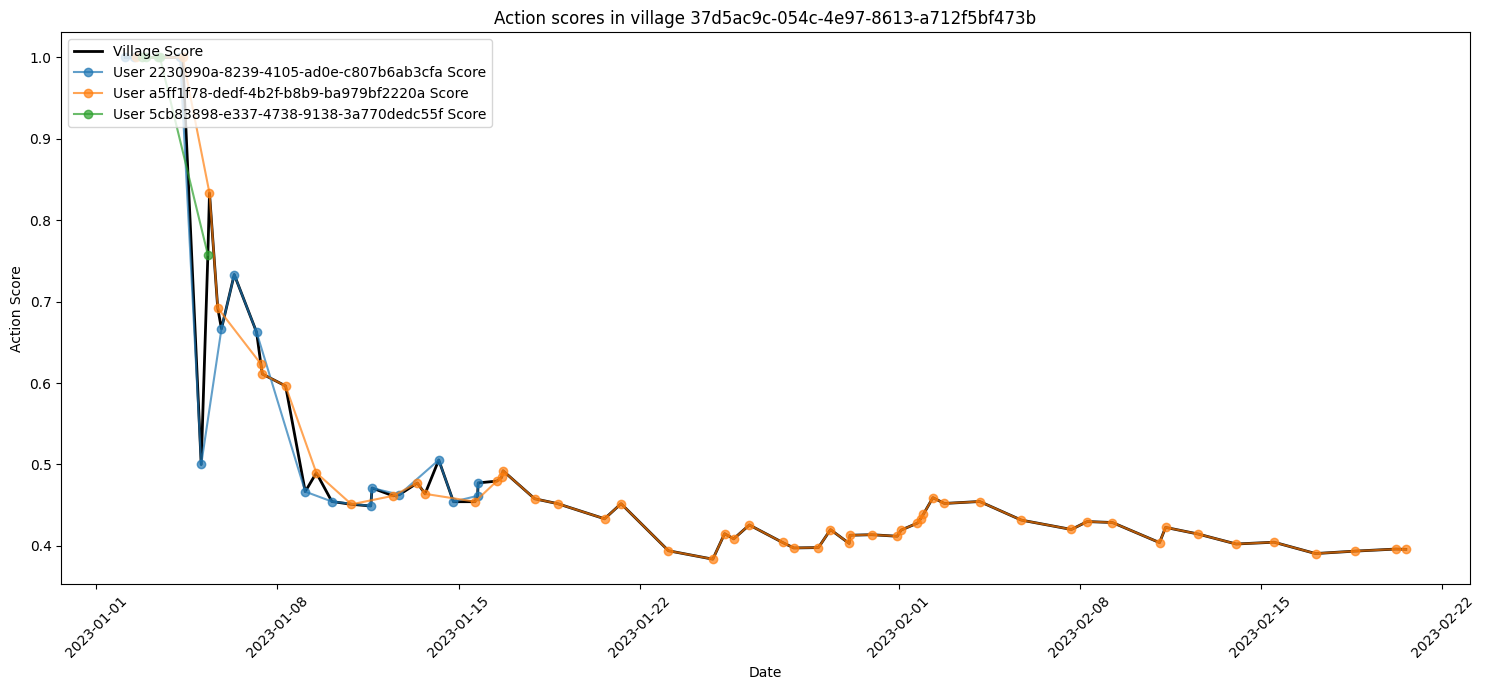

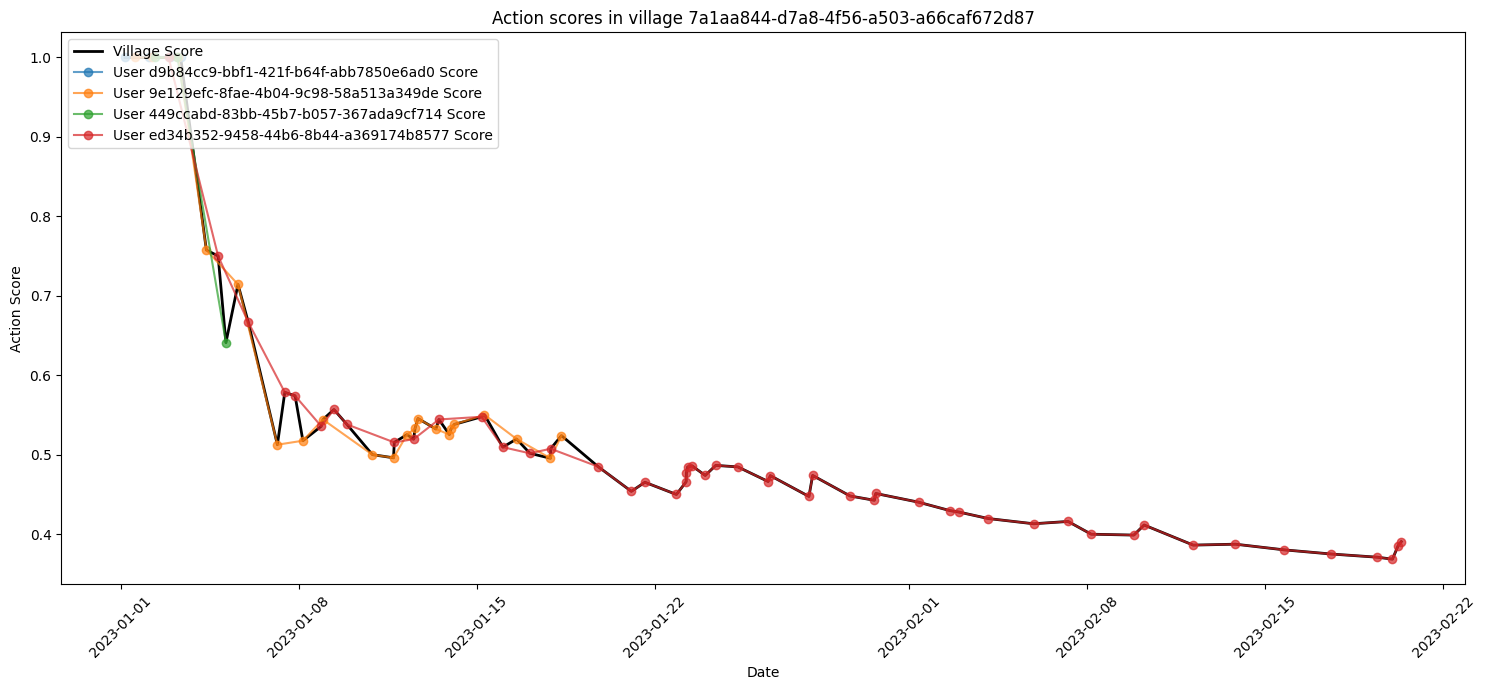

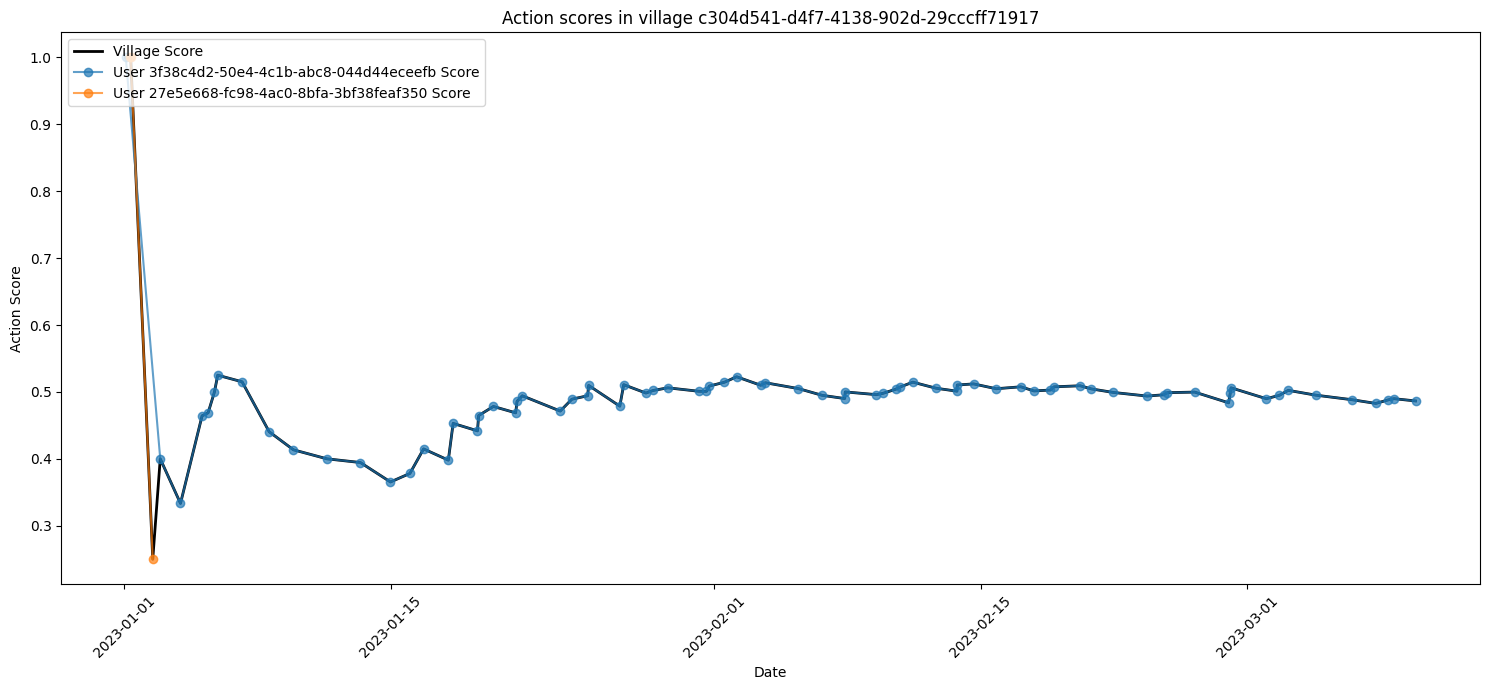

In [46]:
import matplotlib.pyplot as plt
from matplotlib import dates

# Loop through each of the sampled village IDs.
for village_id in sample_village_ids:
    
    # Set a larger figure size for clarity.
    plt.figure(figsize=(15, 7))
    
    # Plot village scores:
    village_actions_df = merged_df[merged_df['village_id_x'] == village_id]
    plt.plot(pd.to_datetime(village_actions_df['datetime']), village_actions_df['score'], label='Village Score', color='black', linewidth=2)
    
    # Get all user IDs associated with this village.
    user_ids = merged_df[merged_df['village_id_x'] == village_id]['user_id'].unique()
    
    # Loop through each user ID to calculate and plot their scores.
    for user_id in user_ids:
        user_actions_df = merged_df[(merged_df['user_id'] == user_id) & (merged_df['village_id_x'] == village_id)]

        # Plotting the user actions with reduced opacity and points for clarity.
        plt.plot(pd.to_datetime(user_actions_df['datetime']), user_actions_df['score'], label=f'User {user_id} Score', alpha=0.7, marker='o')
    
    plt.legend(loc='upper left')  # Set the legend to the upper left to minimize overlap

    # Set the title of the plot to indicate the village's data and its users being visualized.
    plt.title(f'Action scores in village {village_id}')

    # Label the x-axis as 'Date' since it represents the time of actions.
    plt.xlabel('Date')

    # Rotate the x-axis date labels to prevent overcrowding and format the dates.
    plt.xticks(rotation=45)
    date_format = dates.DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_format)

    # Label the y-axis as 'Action Score'.
    plt.ylabel('Action Score')

    # Ensure elements do not overlap.
    plt.tight_layout()

    # Display the plot.
    plt.show()


## 4. Predicting the scores for a village (chosen at random)

In [12]:
# currently chosen at random. Can be changed to specific village id 
sample_village_id = merged_df['village_id_x'].sample(1).tolist()[0]

In [13]:
# import a library to create a prediction ML model
from sklearn.linear_model import LinearRegression

# import a library to split the data into training and testing sets
from sklearn.model_selection import train_test_split

# import a library to measure the accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score


In [14]:
# split the village data into training and testing sets
# we will use the village scores as the target variable

village_actions_df = merged_df[merged_df['village_id_x'] == village_id]

tmp = pd.to_datetime(village_actions_df['datetime'])
X = (tmp - tmp.min()).dt.days

# reshape the data to fit the model
X = np.array(X).reshape(-1, 1)


y = village_actions_df['score']


# split the data into training and testing sets
# we will use 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# reshape the data to fit the model
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

In [15]:
# create a linear regression model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the coefficient of determination (R^2)
r2 = r2_score(y_test, y_pred)

# print the results
print(f"Mean squared error: {mse}")
print(f"Coefficient of determination: {r2}")

Mean squared error: 0.018045960768970422
Coefficient of determination: 0.3603965144968373


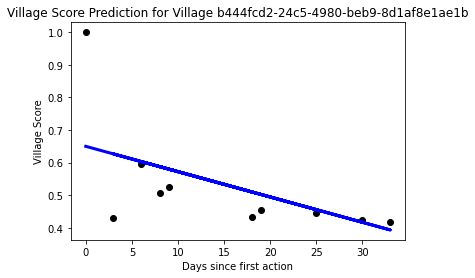

In [16]:
# plot the results
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Days since first action')
plt.ylabel('Village Score')
plt.title('Village Score Prediction for Village ' + str(sample_village_id))
plt.show()